In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install triton

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import torch

import triton
import triton.language as tl


@triton.jit
def add_kernel(x_ptr,  # *Pointer* to first input vector.
               y_ptr,  # *Pointer* to second input vector.
               output_ptr,  # *Pointer* to output vector.
               n_elements,  # Size of the vector.
               BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
               # NOTE: `constexpr` so it can be used as a shape value.
               ):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

In [6]:
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

In [7]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')


tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [8]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

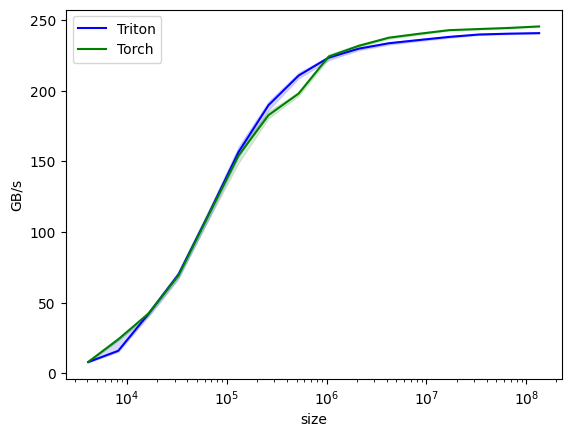

vector-add-performance:
           size      Triton       Torch
0        4096.0    7.836735    7.958549
1        8192.0   15.835052   24.000000
2       16384.0   41.795919   42.082190
3       32768.0   69.818181   69.033707
4       65536.0  112.219181  111.709090
5      131072.0  156.535030  154.081498
6      262144.0  189.776067  182.721182
7      524288.0  210.726687  197.993959
8     1048576.0  223.418180  224.182444
9     2097152.0  229.749344  231.780726
10    4194304.0  233.605218  237.538926
11    8388608.0  235.882423  240.306165
12   16777216.0  238.087263  242.871171
13   33554432.0  239.802413  243.682501
14   67108864.0  240.398009  244.452980
15  134217728.0  240.772900  245.528624


In [9]:
benchmark.run(print_data=True, show_plots=True)


In [10]:
@triton.jit
def sigmoid(x):
    return 1 / (1 + tl.exp(-x))

@triton.jit
def mul_sigm_k(A_ptr, C_ptr, h, w, bs0: tl.constexpr, bs1: tl.constexpr):
    pid_0 = tl.program_id(axis=0)
    pid_1 = tl.program_id(axis=1)

    offs_0 = pid_0 * bs0 + tl.arange(0,bs0)
    offs_1 = pid_1 * bs1 + tl.arange(0,bs1)

    offs = w * offs_0[:,None] + offs_1[None,:]

    mask_0 = offs_0 < h
    mask_1 = offs_1 < w

    mask = mask_0[:,None] & mask_1[None,:]

    A = tl.load(A_ptr + offs, mask = mask)

    sigmoid_A = sigmoid(A)

    C = A * sigmoid(A)

    tl.store(C_ptr + offs, C, mask = mask)


def mul_sigm(A: torch.Tensor, bs):
    # Preallocate the output
    output = torch.empty_like(A, dtype=A.dtype, device=A.device)
    h,w = A.shape

    grid = lambda meta: (triton.cdiv(h, meta['bs0']), triton.cdiv(w,  meta['bs1']))

    mul_sigm_k[grid](A, output, h, w, bs0=bs[0], bs1=bs[1])
    return output


In [11]:
def test_mul_sigm():
    # Define the input tensor
    A = torch.randn((1024, 1024), device='cuda', dtype=torch.float32)

    # Define block sizes
    block_size = (32, 32)

    # Compute the result using the Triton kernel
    result_triton = mul_sigm(A, block_size)

    # Compute the expected result using PyTorch
    sigmoid_A = torch.sigmoid(A)
    expected_result = A * sigmoid_A

    # Validate the results
    assert torch.allclose(result_triton, expected_result, atol=1e-6), "Mismatch between Triton and expected results!"

    print("Test passed!")

In [12]:
test_mul_sigm()

Test passed!


In [13]:
import time

In [14]:
def triton_sigmoid_benchmark(A, block_size, n_iter=5):
    res = 0
    for _ in range(n_iter):
        # Create CUDA events to measure time
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)

        # Warm-up to ensure accurate timing
        for _ in range(10):
            mul_sigm(A, block_size)

        # Record the start time
        start_event.record()

        # Run the Triton kernel
        mul_sigm(A, block_size)

        # Record the end time
        end_event.record()
        torch.cuda.synchronize()

        # Calculate elapsed time in milliseconds
        elapsed_time_ms = start_event.elapsed_time(end_event)
        res += elapsed_time_ms
    return res // n_iter

def torch_sigmoid_benchmark(A, n_iter=5):
    res = 0
    for _ in range(n_iter):
        
        # Create CUDA events to measure time
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)

        # Warm-up to ensure accurate timing
        for _ in range(10):
            torch.sigmoid(A)

        # Record the start time
        start_event.record()

        # Run the PyTorch operation
        sigmoid_A = torch.sigmoid(A)
        result = A * sigmoid_A

        # Record the end time
        end_event.record()
        torch.cuda.synchronize()

        # Calculate elapsed time in milliseconds
        elapsed_time_ms = start_event.elapsed_time(end_event)
        res += elapsed_time_ms
    return res // n_iter


In [17]:
l_n = [128,256,512,1024,2048,4096,8192,16384]
n_iter_rand = 1
res_tritton = []
res_torch = []


for n in l_n:
    c_tritton = 0
    c_torch = 0
    for rng in range(n_iter_rand):
        A = torch.randn((n,n), device='cuda',dtype=torch.float32)
        c_tritton += triton_sigmoid_benchmark(A, (32,32))
        c_torch += torch_sigmoid_benchmark(A)
    res_tritton.append(c_tritton // n_iter_rand)
    res_torch.append(c_torch // n_iter_rand)

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_14105/3992550126.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Comparison of $A\mapsto A \odot \sigma(A)$')


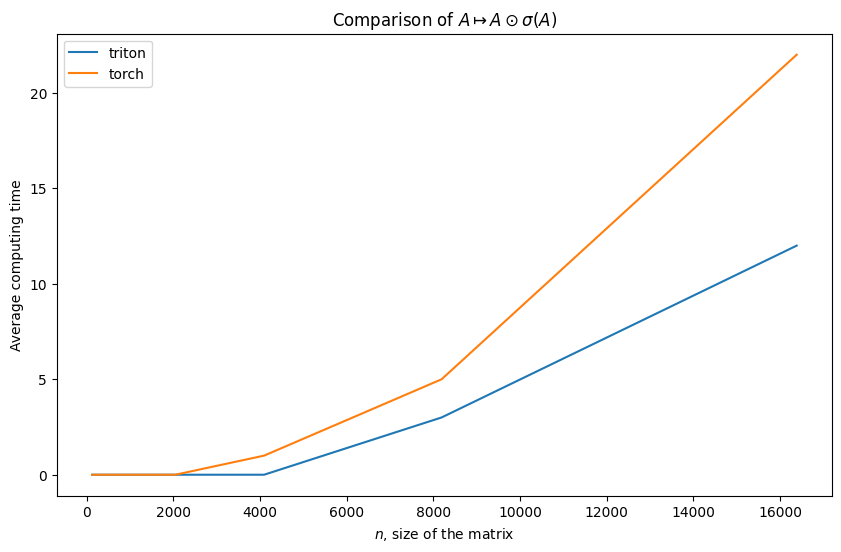

In [19]:
plt.figure(figsize=(10,6))
plt.plot(l_n, res_tritton, label = 'triton')
plt.plot(l_n, res_torch, label = 'torch')
plt.title('Comparison of $A\mapsto A \odot \sigma(A)$')
plt.xlabel('$n$, size of the matrix')
plt.ylabel('Average computing time')
plt.legend()